# **Homework 5 - The eternal significance of publications and citations!**

In [ ]:
import ijson        # For iteratively parsing large JSON files
import pandas as pd # Data manipulation and analysis
import numpy as np  # Numerical operations on arrays and matrices
import networkx as nx  # Creation and manipulation of complex networks
import ast           # Handling Python's abstract syntax trees
import itertools     # Advanced iteration tools
from itertools import combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import seaborn as sns

## **1. Data**
---
In this homework, you will work on a dataset that contains information about a group of papers and their citation relationships. You can find and download the dataset here

### **Graphs setup**
Based on the available data, you will create two graphs to model our relationships as follows:

1. Citation graph: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2. Collaboration graph: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

We modified the [Source Code on Kaggle](https://www.kaggle.com/code/devintheai/citation-network-eda) to efficiently process the JSON file, extracting all relevant details, including author information. The JSON file is converted into a CSV format, and subsequently into a DataFrame. This approach focuses on retaining only essential data, optimizing for memory efficiency.

In [ ]:
PAPERS = []

with open("./dblp.v12.json", "rb") as f:
    for i, element in tqdm(enumerate(ijson.items(f, "item"))):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        authors = element.get('authors')
        if authors:
            paper['num_authors'] = len(authors)
            # joining all authors in a list
            paper['authors'] = [auth for auth in authors]
        else:
            paper['authors'] = np.nan

        year = element.get('year')
        if year:
            paper['year']= year
        else:
            paper['year']= np.nan

        n_citation= element.get('n_citation')
        if n_citation:
             paper['n_citation']= element['n_citation']
        else:
            paper['n_citation']= 0

        doc_type= element.get('doc_type')
        if doc_type:
            paper['doc_type']= element['doc_type']
        else:
            paper['doc_type']= np.nan

        references= element.get('references')
        if references:
            paper['reference_count']= len(references)
            # joining all refs id in a `;` seperated string
            paper['references']= ';'.join([str(int(r)) for r in references])
        else:
            paper['reference_count']= np.nan
            paper['references']= np.nan

        publisher = element.get('publisher')
        if publisher:
            paper['publisher'] = element['publisher']
        else:
            paper['publisher'] = np.nan

        doi = element.get('doi')
        if doi:
            paper['doi']= f"https://doi.org/{element['doi']}"
        else:
            paper['doi']= np.nan


        PAPERS.append(paper)

4894081it [1:29:50, 907.85it/s]  


Now we are going to process the extracted data by transforming it into a DataFrame.
Following this, the DataFrame will be exported and saved as a CSV file named "citations_network.csv". This step ensures that the information is not only structured for easy analysis but also stored in a widely accessible format for future references.

In [ ]:
data = pd.DataFrame(PAPERS)
data.to_csv("citations_network.csv", index = False)

In [ ]:
df = pd.read_csv('itations_network.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4894081 entries, 0 to 4894080
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   title            object 
 2   num_authors      float64
 3   authors          object 
 4   year             float64
 5   n_citation       int64  
 6   doc_type         object 
 7   reference_count  float64
 8   references       object 
 9   publisher        object 
 10  doi              object 
dtypes: float64(3), int64(2), object(6)
memory usage: 410.7+ MB


In [ ]:
df.isnull().sum()

id                       0
title                    0
num_authors             18
authors                 18
year                     9
n_citation               0
doc_type            499441
reference_count    1116974
references         1116974
publisher           759891
doi                 973142
dtype: int64

### **Data pre-processing**
The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

As a result, you will attempt to approximate that most connected component by performing the following steps:

1. Identify the top 10,000 papers with the highest number of citations.

2. Then the nodes of your graphs would be as follows:

  **Citation graph**: you can consider each of the papers as your nodes

  **Collaboration graph**: the authors of these papers would be your nodes

3. For the edges of the two graphs, you would have the following cases:

  **Citation graph**: only consider the citation relationship between these 10,000 papers and ignore the rest.

  **Collaboration graph**: only consider the collaborations between the authors of these 10,000 papers and ignore the rest.

## <span style="color:#c1502e; font-family: Trebuchet MS; font-size: 20px; font-weight: bold;">1. Identify the top 10,000 papers with the highest number of citations</span>

In [ ]:
df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')

# Sorting DataFrame by citation counts in descending order
sorted_papers = df.sort_values(by = 'n_citation', ascending = False)

# Extracting top 10,000 highly cited papers and resetting index
df_top = sorted_papers.head(10000).reset_index(drop=True)

df_top['id'] = df_top['id'].astype(int)
df_top['reference_count'].fillna(0, inplace=True)

# Function to convert string to list if necessary
def convert_to_list(row):
    if isinstance(row, str):
        try:
            return ast.literal_eval(row)
        except ValueError:
            return []  # Return an empty list in case of a conversion error
    return row

# Applying the conversion function to the 'authors' column
df_top['authors'] = df_top['authors'].apply(convert_to_list)

## <span style="color:#c1502e; font-family: Trebuchet MS; font-size: 30px; font-weight: bold;">2. Citation Graph</span>

A citation graph is a directed, unweighted graph used to represent scholarly article relationships, where nodes represent papers and directed edges signify citation relationships.
In this graph, an edge from node A to node B indicates that paper A cites paper B.

## <span style="color:#c1502e; font-family: Trebuchet MS; font-size: 20px; font-weight: bold;">The nodes of the graph</span>

In [ ]:
# We can consider each of the papers (rows) as our nodes
# Creating a directed graph named 'Citation Graph'
cit_G = nx.DiGraph(name = 'Citation Graph')
# Iterating over each paper in the DataFrame 'df_top' to add nodes to the graph
for _, paper in df_top.iterrows():
    # Extracting the paper ID and using it as the node
    node_id = paper['id']
    # Creating a dictionary of attributes excluding the 'id' column
    attributes = paper.drop('id').to_dict()
    # Adding the node with its attributes to the citation graph
    cit_G.add_node(node_id, **attributes)

## <span style="color:#c1502e; font-family: Trebuchet MS; font-size: 20px; font-weight: bold;">The edges of the graph</span>

In [ ]:
# Function to build a mapping of paper citations
def build_citation_map(paper_row, citation_map={}):
    # Check if 'references' data is present
    if pd.notnull(paper_row['references']):
        # Assign paper ID as key and list of cited paper IDs as value
        citation_map[paper_row['id']] = [int(cited_id) for cited_id in paper_row['references'].split(';')]
    return citation_map

In [ ]:
# Initialize an empty map for storing paper citations
citation_relationships = {}

# Iterate through each paper in the DataFrame
for _, paper_data in df_top.iterrows():
    # Populate the citation map with citations from each paper
    citation_relationships = build_citation_map(paper_data, citation_relationships)

Now we will create the directed edges in the citation graph using the dictionary created above

In [ ]:
# Iterate over each item in the citation_relationships dictionary
for citing_paper, cited_papers in citation_relationships.items():
    # Check if the citing paper is a node in the graph
    if citing_paper in cit_G.nodes:
        # Iterate over each paper cited by the citing_paper
        for cited_paper in cited_papers:
            # Check if the cited paper is a node in the graph
            if cited_paper in cit_G.nodes:
                # Add a directed edge from the citing paper to the cited paper
                cit_G.add_edge(citing_paper, cited_paper)


In [ ]:
# Printing the total number of nodes in the Citation Graph
print(f"Number of nodes in the Citation Graph: {len(cit_G.nodes())}")
print(f"Total number of edges in the citation graph : {len(cit_G.edges())}")

Number of nodes in the Citation Graph: 10000
Total number of edges in the citation graph : 52261


Creating a subgraph with around 10 nodes from a larger graph is a great way to get a more manageable and clear view for visualization or analysis.
We'll use NetworkX, to easily create a subgraph from a selection of nodes.

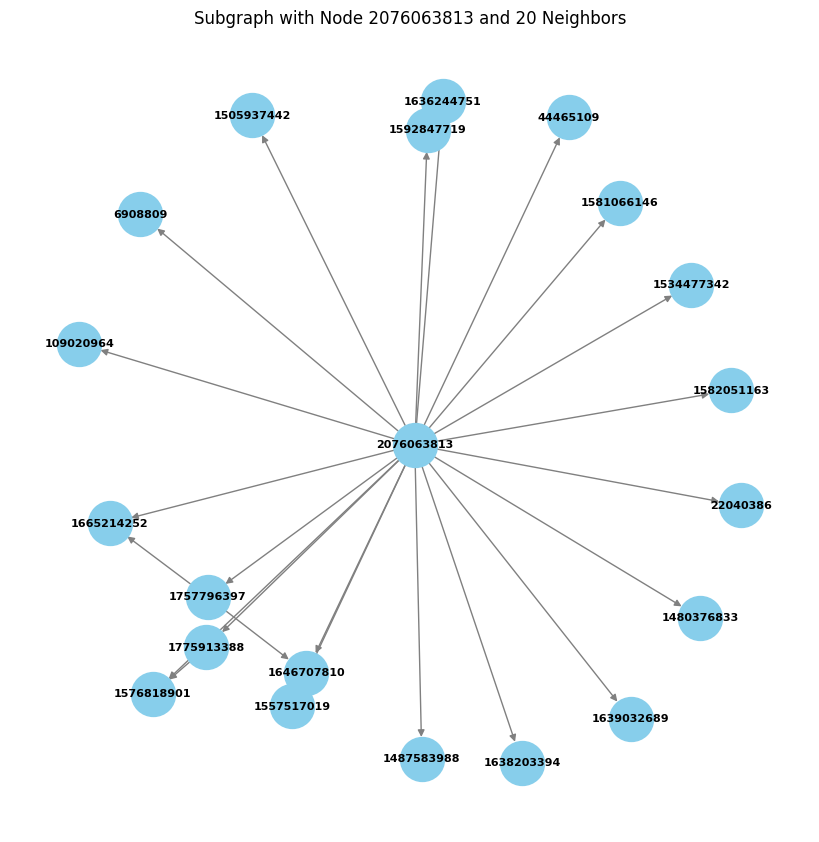

In [ ]:
# Find the node with the highest degree
node_highest_degree = max(cit_G, key=cit_G.out_degree)

# Get all neighbors of the node with the highest degree
all_neighbors = list(cit_G.neighbors(node_highest_degree))

# Select the first 20 neighbors (or less if there are fewer)
selected_neighbors = all_neighbors[:20]

# Create a subgraph with the main node and the selected neighbors
subgraph_nodes = [node_highest_degree] + selected_neighbors
subgraph = cit_G.subgraph(subgraph_nodes)

plt.figure(figsize = (8, 8))
# Plot the subgraph
pos = nx.spring_layout(subgraph)  # You can choose a different layout if needed
nx.draw(subgraph, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", edge_color="gray")

# Add a title
plt.title(f"Subgraph with Node {node_highest_degree} and 20 Neighbors")

# Show the plot
plt.show()


## <span style="color:#c1502e; font-family: Trebuchet MS; font-size: 30px; font-weight: bold;">3. Collaboration Graph</span>

A collaboration graph is an undirected, weighted graph where nodes represent individual authors. Edges between nodes signify collaboration between authors on research papers. The weight of each edge corresponds to the number of joint publications by the connected authors.

In [ ]:
# Initialize an undirected graph named "Collaboration Graph"
collab_G = nx.Graph(name = 'Collaboration Graph')

# Iterating over each paper in the DataFrame 'df_top'
for _, paper_data in df_top.iterrows():
    # Create a list of author IDs for each paper
    author_ids = [author['id'] for author in paper_data['authors']]

    # Update or add nodes for each author
    for author in paper_data['authors']:
        author_id = author['id']
        if author_id not in collab_G.nodes:
            collab_G.add_node(
                author_id,
                name=author['name'],
                org=author.get('org', None),
                papers_published=[{'id': paper_data['id'], 'title': paper_data['title']}]
            )
        else:
            collab_G.nodes[author_id]['papers_published'].append({'id': paper_data['id'], 'title': paper_data['title']})

    # Generate edges for nodes and assign each edge a weight based on the number of collaborations between authors
    if len(author_ids) >= 2:
        for source_node, target_node in combinations(author_ids, 2):
            try:
                current_weight = collab_G[source_node][target_node]['weight']
            except KeyError:
                current_weight = 0

            collab_G.add_edge(source_node, target_node, weight=current_weight + 1)


print(f"Total number of nodes in the collaboration graph: {len(collab_G.nodes())}")
print(f"Total number of edges in the collaboration graph: {len(collab_G.edges())}")

Total number of nodes in the collaboration graph: 21232
Total number of edges in the collaboration graph: 136463


## **2. Controlling system**


---


Please keep the following in mind for both the backend and frontend components. The plan is to put in place a control system. You will provide the user with a menu from which he can select different functionalities. The user should be able to select from one of five different functionalities that you will implement in the following two sections. We want to have such a system so that the user can query different functionalities that he is interested in.

Your function should be designed in such a way that it provides the most flexibility to the user. For example, when the user selects functionality 1, which provides some high-level information about the graph, you can allow him to pass an argument indicating which of the two types of graphs he wants to be analyzed (That is why the name of the graph is one of the arguments in the first functionality).

You will implement the functionalities in the Backend section. The Frontend section primarily discusses the menu that you must provide to the user, as well as the expected results that should be displayed to the user after selecting each of the functionalities.

### **2.1. Backend Implementation**
This section describes what each of the functionalities should be.


#### **Functionality 1 - Graph's features**
This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below.

Input:
- The graph
- The name of the graph

Output:
- The number of the nodes in the graph
- The number of the edges in the graph
- The graph density
- The graph degree distribution
- The average degree of the graph
- The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the graph is dense or sparse

> 1. graph_info(graph, graph_name): This function takes a graph (graph) and a name (graph_name) as input and computes various properties of the graph.
It calculates the total number of nodes and edges in the given graph.
Computes the density (edge-to-node ratio) and the degree distribution (a list of node degrees).
Calculates the average degree and the 95th percentile of the degree distribution.
Finds nodes that are considered hubs (nodes with a degree greater than the 95th percentile).
Determines whether the graph is classified as "dense" or "sparse" based on its density.
Returns a tuple containing the calculated values.

> 2. graph_features(graph, graph_name)
This function utilizes the graph_info function to extract information and prints an analysis report for a given graph.
Prints out key information about the graph, including the number of nodes, edges, density, degree distribution, average degree, and whether the graph is dense or sparse.
Converts the list of hubs into a Pandas DataFrame for a tabular representation.
Prints the analysis report and the table of hub nodes.

In [ ]:
def graph_info(graph, graph_name):
    # Number of nodes and edges
    num_nodes,num_edges = len(graph.nodes()),len(graph.edges())

    # Density and degree distribution
    density, degree_distribution = nx.density(graph),list(dict(graph.degree()).values())

    # Average degree and 95th percentile of the degree distribution
    average_degree,per_95 = np.mean(degree_distribution), np.percentile(degree_distribution, 95)

    # Graph hubs
    hubs = [node for node, degree in graph.degree() if degree > per_95]

    # Dense or sparse
    den_or_spa = "dense" if density >= 0.5 else "sparse"

    return num_nodes,num_edges,density,degree_distribution,average_degree,den_or_spa,hubs


def graph_features(graph,graph_name):
    num_nodes,num_edges,density,degree_distribution,average_degree,den_or_spa,hubs=graph_info(graph,graph_name)
    # Output the report
    print(f"Analysis Report for {graph_name}:")
    print(f"Number of Nodes: {num_nodes}")
    print(f"Number of Edges: {num_edges}")
    print(f"Graph Density: {density:.4f}")
    print(f"Graph Degree Distribution: {degree_distribution}")
    print(f"Average Degree: {average_degree:.2f}")
    #print(f"Graph Hubs: {hubs}")
    print(f"Graph is {den_or_spa}")

    # Convert hubs to a Pandas DataFrame for tabular representation
    hubs_df = pd.DataFrame({"Hub Nodes": hubs})
    print(f"Graph Hubs for {graph_name}:")
    print(hubs_df)
    print()


In [ ]:
graph_features(collab_G, 'Collaboration Graph')

Analysis Report for Collaboration Graph:
Number of Nodes: 21232
Number of Edges: 136463
Graph Density: 0.0006
Graph Degree Distribution: [0, 10, 2, 8, 0, 4, 1, 1, 12, 29, 3, 1, 8, 109, 12, 4, 9, 4, 3, 3, 8, 8, 8, 8, 8, 17, 27, 1, 2, 9, 1, 1, 21, 61, 48, 12, 12, 12, 12, 12, 174, 52, 12, 12, 304, 17, 18, 18, 12, 1, 12, 43, 4, 10, 3, 16, 6, 9, 5, 4, 6, 6, 6, 6, 6, 6, 6, 7, 9, 4, 74, 37, 4, 3, 15, 0, 2, 1, 0, 1, 17, 3, 4, 22, 0, 1, 1, 8, 3, 3, 2, 3, 10, 1, 1, 7, 12, 6, 9, 5, 14, 182, 72, 3, 9, 1, 5, 11, 11, 5, 0, 10, 2, 2, 12, 12, 12, 12, 12, 18, 12, 12, 12, 12, 29, 12, 12, 163, 153, 129, 15, 17, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 20, 8, 7, 76, 60, 182, 96, 91, 15, 15, 33, 15, 18, 15, 24, 32, 38, 279, 116, 27, 3, 3, 21, 17, 5, 5, 3, 19, 12, 2, 0, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 10, 15, 16, 6, 2, 3, 3, 3, 3, 17, 5, 20, 17, 15, 35, 2, 5, 5, 2, 5, 2, 7, 5, 12, 54, 4, 2, 2, 12, 4, 35, 3, 21, 3, 1, 3, 4, 4, 4, 1, 4, 0, 35, 2, 20, 4, 18, 3, 0, 1, 4, 3, 6, 3, 30, 23, 13, 26, 13

#### **Functionality 2 - Nodes' contribution**
Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements.

Input:
- The graph
- A node of the graph (paper/author)
- The name of the graph

Output:
- The centrality of the node, calculated based on the following centrality measurements:
  - Betweeness
  - PageRank
  - ClosenessCentrality
  - DegreeCentrality

> This function, *node_contribution*, calculates various centrality measures for a specified node in a given graph. The centrality measures provide insights into the importance or influence of a node within the graph. Here's a breakdown of what each part of the function does:
- Calculates the betweenness centrality of the specified node in the graph. Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes in the graph.
- Computes the PageRank of the specified node. PageRank is a measure of a node's importance in a graph based on the idea that important nodes are linked to by other important nodes.
- Calculates the closeness centrality of the specified node. Closeness centrality measures how close a node is to all other nodes in the graph, considering the shortest paths.
- Computes the degree centrality of the specified node. Degree centrality is a simple measure based on the number of edges connected to a node, indicating how well-connected the node is in the graph.

> Returns a tuple containing the calculated centrality measures (betweenness, PageRank, closeness, and degree) for the specified node.

In [ ]:
def node_contribution(graph, node, graph_name):
    # Betweenness
    betweenness = nx.betweenness_centrality(graph)[node]

    # PageRank
    pagerank = nx.pagerank(graph)[node]

    # Closeness
    closeness = nx.closeness_centrality(graph)[node]

    # Degree
    degree = nx.degree_centrality(graph)[node]

    return betweenness,pagerank,closeness,degree

#### **Functionality 3 - Shortest ordered walk**

Input:
- The graph data
- A sequence of authors_a = [a_2, ..., a_{n-1}]
- Initial node a_1 and an end node a_n
- *N*: denoting the top *N* authors whose data should be considered

Output:
- The shortest walk of collaborations you need to read to get from author a_1 to author a_n and the papers you need to cross to realize this walk.

Considerations: For this functionality, you must implement an algorithm that returns the shortest walk that goes from node a_j to a_n, which visits in order the nodes in a. The choice of a_j and a_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way)

Important Notes:
- This algorithm should be run only on the collaboration graph.
- The algorithm needs to handle the case that the graph is not connected. Thus, only some nodes in a are reachable from a_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path."
- Since we are dealing with walks, you can pass on the same node a_i more than once, but you must preserve order. It means you can go back to any author node any time you want, assuming that the order in which you visit the required nodes is still the same.
- Once you completed your implementation, ask chatGPT for a different one leveraging another approach in solving the shortest path and prove whether this implementation is correct.


> This `shortest_ordered_walk` function performs a breadth-first search (BFS) to find the shortest path in a collaboration graph between two specified authors, considering a sequence of authors and limiting the search to a top N subset of authors. Here's a breakdown of the code:
   - Extracts the top N authors based on their degree (collaboration count) and creates a subgraph (`graph_N`) using only those authors.
   - Initializes variables for storing the shortest walk, a BFS queue, and a set to track visited authors.
   - Executes BFS to find the shortest path between `start_author` and `end_author` considering the specified sequence of authors (`authors_sequence`).
   - Checks if the current author is the desired end author, and if the specified author sequence is a subset of the path. If true, updates the `shortest_walk` variable and breaks the loop.
   - Gets neighbors of the current author and sorts them based on collaboration weight in descending order.
   - Adds unvisited neighbors to the queue along with the updated path.
   - If no path is found, returns a message indicating that there is no such path.
   - Extracts a subgraph based on the nodes and edges of the shortest walk for visualization.
   - Iterates through the shortest walk and extracts the titles of publications for each author, storing common publications in a dictionary.
   - Returns the shortest walk, publications titles by author, subgraph for visualization, and the original graph_N (subgraph of top N authors).

In [ ]:
def shortest_ordered_walk(graph, authors_sequence, start_author, end_author, N):
    # Extract the top N authors and create a subgraph of the collaboration graph
    top_N_authors = sorted(graph.degree, key=lambda x: x[1], reverse=True)[:N]
    graph_N = graph.subgraph([author[0] for author in top_N_authors])

    # Initialize a list to store the shortest walk
    shortest_walk = []

    # Implement BFS to find the shortest path
    queue = [(start_author, [start_author])]
    visited = set()

    while queue:
        current_author, path = queue.pop(0)

        if current_author == end_author and set(authors_sequence).issubset(path):
            shortest_walk = path
            break

        if current_author not in visited:
            visited.add(current_author)

            # Get neighbors of the current author
            neighbors = list(graph_N.neighbors(current_author))

            # Sort neighbors based on collaboration weight
            neighbors.sort(key=lambda neighbor: graph_N[current_author][neighbor]['weight'], reverse=True)

            for neighbor in neighbors:
                if neighbor not in visited:
                    queue.append((neighbor, path + [neighbor]))

    # If no path is found, return a message
    if not shortest_walk:
        return "There is no such path."

    # Extracting the subgraph for visualization
    subgraph_nodes = set(shortest_walk)
    subgraph_edges = [(shortest_walk[i], shortest_walk[i + 1]) for i in range(len(shortest_walk) - 1)]
    subgraph = graph.subgraph(subgraph_nodes).edge_subgraph(subgraph_edges)

    # Extract the titles of publications for each author in the shortest walk
    publications_titles_by_author = {}
    # Extract the titles of publications for each author in the shortest walk
    for i in range(len(shortest_walk) - 1):
        current_author = shortest_walk[i]
        next_author = shortest_walk[i + 1]

        # Get publications for the current and next authors
        current_publications = set(paper['title'] for paper in graph_N.nodes[current_author]['papers_published'])
        next_publications = set(paper['title'] for paper in graph_N.nodes[next_author]['papers_published'])

        # Find the intersection of publications
        common_publications = current_publications.intersection(next_publications)

        # Store common publications in the dictionary
        publications_titles_by_author[current_author] = list(common_publications)


    return shortest_walk, publications_titles_by_author, subgraph, graph_N


> This function get_node_name retrieves the name of a node in the graph based on its node ID.
  - Accesses the node with the specified ID in the graph.
  - Retrieves the 'name' attribute of the node.
  - Returns the name of the node.


> path_output prints information about the shortest walk and the papers crossed during the walk.
  - Iterates through each node in the shortest walk.
  - Retrieves and prints the ID and name of each node using `get_node_name`.
  - Prints information about the papers crossed during the walk for each author.

>  This function, path_info, combines the result of the `shortest_ordered_walk` function with the `path_output` function to print information about the path or return a message if no path is found.
  - Calls `shortest_ordered_walk` to get the result.
  - If the result is "There is no such path," it returns the message.
  - Otherwise, it calls `path_output` to print information about the path and papers crossed.

In [ ]:
def get_node_name(graph, node_id):
  node_name = graph.nodes[node_id].get('name')
  return node_name


def path_output(graph,shortest_walk,publications_titles_by_author):
  for node_id in shortest_walk:
      node_name = get_node_name(graph, node_id)
      print(f"  {node_id} ({node_name})")
  print("Papers Crossed:")
  subgraph_titles = publications_titles_by_author
  for author, titles in subgraph_titles.items():
      print(f"Author {author} ({get_node_name(graph, author)}): {titles}")


def path_info(graph, authors_sequence, start_author, end_author, N):
  result=shortest_ordered_walk(graph, authors_sequence, start_author, end_author, N)
  if result=="There is no such path.":
    return result
  else:
    path_output(graph,result[0],result[1])

In [ ]:
a=[1973035492]
start=2130160582
end=2111642879
N=40
path_info(collab_G,a,start,end,N)

Shortest Ordered Path:
  2130160582 (Andrea Califano)
  1973035492 (Julian Gough)
  2111642879 (Darren A. Natale)
Papers Crossed:
Author 2130160582 (Andrea Califano): ['A promoter-level mammalian expression atlas']
Author 1973035492 (Julian Gough): ['InterPro: the integrative protein signature database', 'InterPro in 2011: new developments in the family and domain prediction database', 'InterPro in 2017—beyond protein family and domain annotations', 'The InterPro protein families database: the classification resource after 15 years']


> Now let's ask ChatGPT:

In [ ]:
def shortest_ordered_walk2(graph, authors_sequence, initial_node, end_node, top_N):
    """
    Find the shortest ordered walk between two nodes in the collaboration graph.

    Parameters:
    - graph: NetworkX graph (Collaboration Graph)
    - authors_sequence: List of authors_a [a_2, ..., a_{n-1}]
    - initial_node: Initial node a_1
    - end_node: End node a_n
    - top_N: Top N authors whose data should be considered

    Returns:
    - Shortest ordered walk as a list of nodes
    - Papers needed to realize the walk as a list
    """
    # Restrict the graph to the top N authors
    top_N_authors = set(sorted(graph.nodes, key=lambda x: graph.nodes[x].get('collaborations', 0), reverse=True)[:top_N])
    graph_subset = graph.subgraph(top_N_authors)

    # Check if initial and end nodes are in the top N authors
    if initial_node not in top_N_authors or end_node not in top_N_authors:
        return "There is no such path."

    # Find the shortest path using NetworkX's built-in function
    try:
        path_nodes = nx.shortest_path(graph_subset, source=initial_node, target=end_node)
    except nx.NetworkXNoPath:
        return "There is no such path."

    # Extract papers needed to realize the walk
    visited_papers = set()
    for i in range(len(path_nodes) - 1):
        edge_data = graph_subset[path_nodes[i]][path_nodes[i + 1]]
        visited_papers.update(edge_data.get('papers', []))

    return path_nodes, list(visited_papers)


In [ ]:
shortest_ordered_walk2(collab_G,a,start,end,N)

'There is no such path.'

> The generated output differs from our custom function, which could be attributed to potential issues with the argument formats provided to functions requiring specific formats for optimal performance. In this instance, the implementation utilizes Dijkstra's algorithm.

#### **Functionality 4 - Disconnecting Graphs**
Input:
- The graph data
- authorA: a paper to which will relate sub-graph G_a
- authorB: a paper to which will relate sub-graph G_b
- *N*: denoting the top *N* authors that their data should be considered

Output:
- The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G_a and G_b.


#### **Functionality 5 - Extracting Communities**
Input:
- The graph data
- *N*: denoting the top *N* papers that their data should be considered
- Paper_1: denoting the name of one of the papers
- Paper_2: denoting the name of one of the papers

Output:
- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of papers that belong to them.
- Whether the Paper_1 and Paper_2 belongs to the same community.

Important Notes:
To comprehend this functionality better, we suggest you take a good look at this article



### **2.2. Frontend Implementation**
This section describes how the final results for each functionality implemented in the backend section should be presented to the user.

Please run at least one query for each functionality in the final version of the notebook and comment on the results.



#### **Visualization 1 - Visualize graph features**
We anticipate seeing the Functionality 1 report in Visualization 1. To be more specific, we expect you to have the following report format:
- A table containing the following general information about the graph:
  - Number of nodes in the graph
  - Number of the edges in the graph
  - Density of the graph
  - Average degree of the graph
- Whether the network is sparse or dense
- A table that lists the graph's hubs
- A plot depicting the distribution of the citations received by papers (Citation graph)
- A plot depicting the distribution of the given citations by papers (Citation graph)
- A plot depicting the number of collaborations of the author (Collaboration graph)

**Note**: You can plot the features for a limited number of nodes (e.g., top 20) to improve the visualization of the plots.

> This function is designed to visualize graph features and specific distributions for the top nodes in the given graph.
Calls the graph_features function to display general information about the graph, such as the number of nodes, edges, density, degree distribution, average degree, and graph type (dense or sparse).
Extracts data for the top nodes based on the specified number (top_nodes) from a DataFrame named df_top. It assumes the existence of this DataFrame, which should contain relevant information about the graph nodes.
Visualization for 'Citation Graph':
If the graph is a 'Citation Graph', it visualizes two distributions: citations received by papers and given citations by papers. It uses Seaborn and Matplotlib for creating histograms with kernel density estimates.
Visualization for 'Collaboration Graph':
If the graph is a 'Collaboration Graph', it visualizes the number of collaborations for each author using a bar plot.

In [ ]:
def visualize_graph_features(graph, graph_name, top_nodes=20):
    # Visualize general info
    graph_features(graph, graph_name)

    top_nodes_data = df_top.head(top_nodes)

    if graph_name == 'Citation Graph':
        # Distribution of citations received by papers
        plt.figure(figsize=(8, 8))
        sns.histplot(top_nodes_data['n_citation'], bins=20, kde=True)
        plt.title(f'Distribution of Citations Received by Papers ({graph_name})')
        plt.xlabel('Number of Citations')
        plt.ylabel('Frequency')
        plt.show()
        print()
        # Distribution of given citations by papers
        plt.figure(figsize=(8, 8))
        sns.histplot(top_nodes_data['reference_count'], bins=20, kde=True)
        plt.title(f'Distribution of Given Citations by Papers ({graph_name})')
        plt.xlabel('Number of Citations Given')
        plt.ylabel('Frequency')
        plt.show()

    if graph_name == 'Collaboration Graph':
        # Number of collaborations of each author
        plt.figure(figsize=(8, 8))
        sns.barplot(x=top_nodes_data['authors'].apply(len), y=top_nodes_data['authors'].apply(lambda x: x[0]['name']), errorbar=None)
        plt.title(f'Number of Collaborations by Authors ({graph_name})')
        plt.xlabel('Number of Collaborations')
        plt.ylabel('Author')
        plt.show()

Analysis Report for Collaboration Graph:
Number of Nodes: 21232
Number of Edges: 136463
Graph Density: 0.0006
Graph Degree Distribution: [0, 10, 2, 8, 0, 4, 1, 1, 12, 29, 3, 1, 8, 109, 12, 4, 9, 4, 3, 3, 8, 8, 8, 8, 8, 17, 27, 1, 2, 9, 1, 1, 21, 61, 48, 12, 12, 12, 12, 12, 174, 52, 12, 12, 304, 17, 18, 18, 12, 1, 12, 43, 4, 10, 3, 16, 6, 9, 5, 4, 6, 6, 6, 6, 6, 6, 6, 7, 9, 4, 74, 37, 4, 3, 15, 0, 2, 1, 0, 1, 17, 3, 4, 22, 0, 1, 1, 8, 3, 3, 2, 3, 10, 1, 1, 7, 12, 6, 9, 5, 14, 182, 72, 3, 9, 1, 5, 11, 11, 5, 0, 10, 2, 2, 12, 12, 12, 12, 12, 18, 12, 12, 12, 12, 29, 12, 12, 163, 153, 129, 15, 17, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 20, 8, 7, 76, 60, 182, 96, 91, 15, 15, 33, 15, 18, 15, 24, 32, 38, 279, 116, 27, 3, 3, 21, 17, 5, 5, 3, 19, 12, 2, 0, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 10, 15, 16, 6, 2, 3, 3, 3, 3, 17, 5, 20, 17, 15, 35, 2, 5, 5, 2, 5, 2, 7, 5, 12, 54, 4, 2, 2, 12, 4, 35, 3, 21, 3, 1, 3, 4, 4, 4, 1, 4, 0, 35, 2, 20, 4, 18, 3, 0, 1, 4, 3, 6, 3, 30, 23, 13, 26, 13

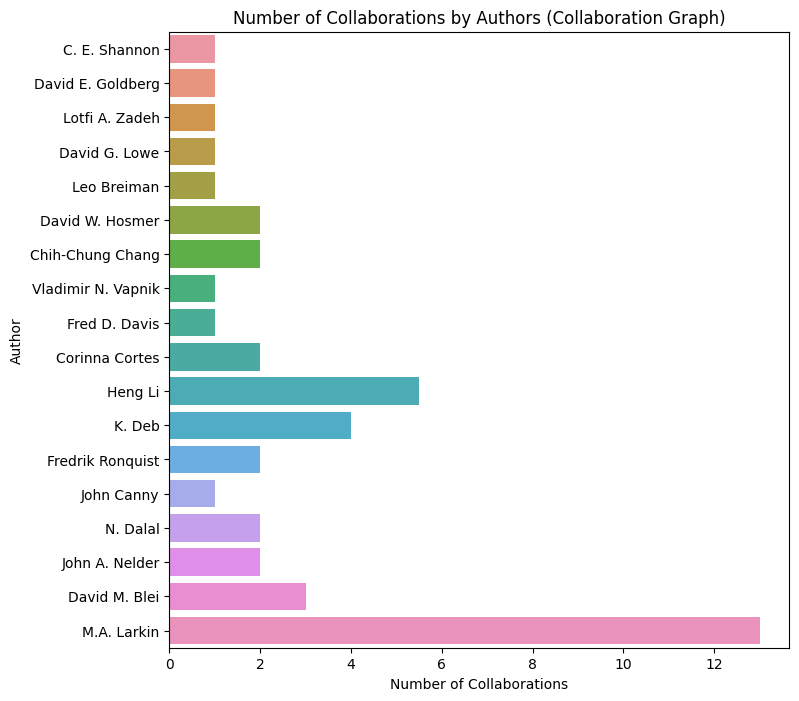

In [ ]:
visualize_graph_features(collab_G,"Collaboration Graph")

#### **Visualization 2 - Visualize the node's contribution**
We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:
- A table containing the node's centrality value based on the four centrality measurements

> This visualize_node_contribution function takes a graph, a specific node, and the graph's name as input, calculates various centrality measures for that node using the node_contribution function, and returns the results in a Pandas DataFrame for easy visualization.

In [ ]:
def visualize_node_contribution(graph, node, graph_name):
    betweenness, pagerank, closeness, degree = node_contribution(graph, node, graph_name)

    # Create a table with the centrality measures
    centrality_df = pd.DataFrame({
        'Node': [node],
        'Betweenness Centrality': [betweenness],
        'PageRank Centrality': [pagerank],
        'Closeness Centrality': [closeness],
        'Degree Centrality': [degree]
    })

    return centrality_df

In [ ]:
node_id=random.choice(list(cit_G.nodes()))
visualize_node_contribution(cit_G, node_id, 'Collaboration Graph')

,Node,Betweenness Centrality,PageRank Centrality,Closeness Centrality,Degree Centrality
0,2019746085,2.095629e-07,0.000075,0.000229,0.0004


#### **Visualization 3 - Visualize the shortest-ordered route**
We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:
- Print the papers needed to be crossed in the shortest walk in order
- Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

> This  function `visualize_shortest_route` visualizes the shortest route between two authors in a collaboration graph. Here's a breakdown of the code:
   - Calls the `shortest_ordered_walk` function to find the shortest ordered walk between the specified start and end authors in the collaboration graph.
   - If there is no such path, it returns the corresponding message.
   - If a valid result is obtained, it extracts the nodes in the shortest walk, the publications titles by author, the subgraph of the shortest walk, and the original graph_N.
   - Calls the `path_output` function to print information about the shortest walk and the papers crossed during the walk.
   - Creates a visualization of the subgraph of the collaboration network.
   - Uses NetworkX to draw edges, nodes, and labels with specific formatting.
   - Highlights nodes and edges in the shortest walk using different colors.
   - Displays order numbers on edges in the shortest walk.
   - Shows the visualization using Matplotlib.


In [ ]:
def visualize_shortest_route(graph, authors_sequence, start_author, end_author, N):
  result = shortest_ordered_walk(graph, authors_sequence, start_author, end_author, N)
  if result=="There is no such path.":
    return result

  else:
    shortest_walk_nodes, publications_titles_by_author,shortest_walk_subgraph, graph_N = result
    path_output(graph,shortest_walk_nodes,publications_titles_by_author)

    # Plot the subgraph with all nodes and highlight those in the shortest walk
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(graph_N)  # Use layout of the original top N subgraph

    # Draw edges first
    nx.draw_networkx_edges(graph_N, pos, edge_color='gray', width=1, alpha=0.5)

    # Draw nodes next
    nx.draw_networkx_nodes(graph_N, pos, node_color='skyblue', label="All Nodes")

    # Highlight nodes in the shortest walk
    nx.draw_networkx_nodes(graph_N, pos, nodelist=shortest_walk_nodes, node_color='red', label="Shortest Walk Nodes")

    # Highlight edges in the shortest walk with order numbers
    edges_in_walk = [(shortest_walk_nodes[i], shortest_walk_nodes[i + 1]) for i in range(len(shortest_walk_nodes) - 1)]
    edge_labels = {(edges_in_walk[i]): i + 1 for i in range(len(edges_in_walk))}
    nx.draw_networkx_edges(graph_N, pos, edgelist=edges_in_walk, edge_color='red', width=2, label="Shortest Walk Edges")
    nx.draw_networkx_edge_labels(graph_N, pos, edge_labels=edge_labels, font_color='blue')

    # Draw labels last
    nx.draw_networkx_labels(graph_N, pos, font_size=8)

    plt.title("Subgraph of Collaboration Network ")
    plt.legend()
    plt.show()

  2502209291 (Xiaobei Zhao)
  1524700667 (Timo Lassmann)
  2120643991 (Alex Bateman)
  2111642879 (Darren A. Natale)
Papers Crossed:
Author 2502209291 (Xiaobei Zhao): ['A promoter-level mammalian expression atlas']
Author 1524700667 (Timo Lassmann): ['Pfam: clans, web tools and services']
Author 2120643991 (Alex Bateman): ['The InterPro protein families database: the classification resource after 15 years', 'Activities at the Universal Protein Resource (UniProt)', 'InterPro in 2017—beyond protein family and domain annotations', 'UniProt: A hub for protein information', 'InterPro in 2011: new developments in the family and domain prediction database', 'InterPro: the integrative protein signature database']


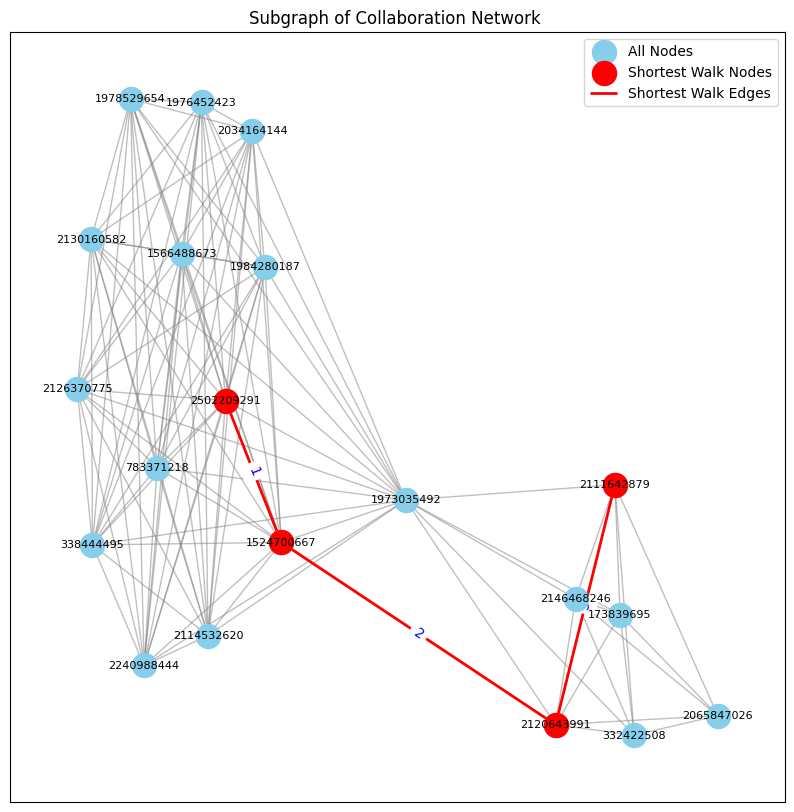

In [ ]:
a=[1524700667]
start=2502209291
end=2111642879
N=20
visualize_shortest_route(collab_G,a,start,end,N)

#### **Visualization 4 - Visualize the disconnected graph**
We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:
- Print the number of the links that should be disconnected
- Plot the original graph
- Plot the graph after removing the links and identify the two nodes

#### **Visualization 5 - Visualize the communities**
We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:
- Print the number of links that should be removed to have the communities
- A table depicting the communities and the papers that belong to each community
- Plot the original graph
- Plot the graph showing the communities in the network
- Plot the final graph and identify the community/communities of Paper_1 and Paper_2

## **3. Bonus - PageRank on MapReduce**


---
**IMPORTANT**: This is a bonus step, so it's not mandatory. You can get the maximum score without doing this. We will consider this, only if the rest of the homework has been completed.

Working with big data has become increasingly important in the modern era as the volume and complexity of data generated grows. In this part, we ask you to implement the PageRank algorithm using MapReduce paradigm to compute the importance of papers based on the citation relationship.

Since a large dataset is required to fully understand the power of this paradigm, when creating the Citation graph, consider the top 1,000,000 papers that have received the most citations; then, make the graph exclusively for those papers.

**Hint**: Here are two approaches to implement the PageRank algorithm using the MapReduce paradigm that you can use as a reference for your bonus part.


## **4. Command Line Question (CLQ)**

---
In this question, you should use any command line tools that you know to answer the following questions using the directed and unweighted graph that you have previously created: Citation graph:

1. Is there any node that acts as an important "connector" between the different parts of the graph?
2. How does the degree of citation vary among the graph nodes?
3. What is the average length of the shortest path among nodes?

**Important note**: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a screenshot of the output in the notebook for evaluation.


## 5. Algorithmic Questions (AQ)


---



**Part A**

A sports club hires you to create a team for the National Sports Championship. Every Italian Region sends its best *M* athletes to compete in an intense 2-day sports event, and Rome is no exception!

The trainers of Team Rome need to carefully choose the best *M* athletes from a pool of *N* candidates. Each athlete is uniquely identified by a number from 1 to *N* and possesses a set of *S* sports skills. Each skill is represented by a 3-character string with only uppercase letters and a non-negative integer indicating the athlete's proficiency in that skill (always greater than 0).

The trainers have extensively studied the competition format and established an optimal set of (possibly repeated) skills the team should possess to ensure the best possible performance. Each of the ten selected athletes will be assigned one of these skills as their role within the team.

The team's overall score is the sum of the skill scores of its members in the roles they have been assigned. Other skills of each athlete do not contribute to the team's score.

Your task is to determine the maximum possible global score for Team Rome, given the list of candidates.

Note: Assigning an athlete to a role not listed in their skills is possible. In that case, that athlete's contribution to the global score will be 0.

**Input** The input consists of *2+N(S+1)* lines:
- Line 1: the numbers *N*,*M* and *S*, separated by a space.
- Line 2: the optimal set of skills required by the trainers, as a list of *M* space-separated skill names.
- Lines 3, . . . , *2+N(S+1)*: every group of *S+1* lines is formatted as follows:
  - Line 1: the unique id of the athlete.
  - Lines 2, . . . , *S+1*: one skill name and the corresponding skill score, separated by a space.

**Output** Print the maximum global score that can be achieved with the available athletes.

Your job:
1. Implement an algorithm to solve the described mentioned problem.
2. What is the time complexity (the Big O notation) of your solution? Please provide a detailed explanation of how you calculated the time complexity.
3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. If the two differ, which one is right? (why?)
4. If you algorithm has exponential time complexity, can you provide a polynomial-time version?
5. If *S=1*, how does the time complexity of an optimal algorithm to solve this problem change?

> - Algorithm Implementation:  Our solution implements a sorting-based greedy approach to select athletes based on their proficiency in the specified skills. It iterates through the specified skills and selects the best athlete for each skill based on their score.
- Time Complexity Analysis:
Sorting the athletes based on their skills' maximum scores takes O(N * S * log N) time, where N is the number of athletes and S is the number of skills each athlete possesses.
The nested loops that follow iterate through the specified optimal skills and search for the best athlete. In the worst case, for each skill, it iterates through the sorted list of athletes, resulting in O(M * N) iterations.
Combining these, the overall time complexity of the solution is O(N * S * log N + M * N), dominated by the sorting step.
- Optimizing Exponential Complexity:
Our current solution doesn't exhibit exponential complexity. However, if it did, exploring dynamic programming or memoization techniques might help convert it into a polynomial-time solution by avoiding repeated calculations.
- Impact of S=1:
When S=1 (each athlete has only one skill), the sorting step becomes O(N * log N), and the subsequent iteration through the skills remains O(M * N). Thus, the overall complexity becomes O(N * log N + M * N).

In [ ]:
def max_global_score(N, M, S, optimal_skills, athletes):
    sorted_athletes = sorted(athletes.items(), key=lambda x: max([x[1].get(skill, 0) for skill in optimal_skills]), reverse=True)

    selected_athletes = set()
    max_score = 0

    for skill in optimal_skills:
        for athlete_id, athlete_skills in sorted_athletes:
            if athlete_id not in selected_athletes and skill in athlete_skills:
                max_score += athlete_skills[skill]
                selected_athletes.add(athlete_id)
                break

    return max_score

# Sample inputs
N, M, S = 14, 10, 1  # Example values for N, M, S

required_skills = ["SWM", "VOL", "ATH", "VOL", "VOL", "BSK", "HCK", "BSK", "SWM", "BSK"]

athletes = {
    1: {"BSK": 98},
    2: {"ATH": 14},
    3: {"HCK": 82},
    4: {"HCK": 9},
    5: {"FTB": 90},
    6: {"ATH": 52},
    7: {"HCK": 95},
    8: {"TEN": 85},
    9: {"RGB": 46},
    10: {"SWM": 16},
    11: {"VOL": 32},
    12: {"SOC": 41},
    13: {"SWM": 59},
    14: {"SWM": 34}
}

# Calculate and display the result
result = max_global_score(N, M, S, required_skills, athletes)
print(f"The maximum global score achievable is: {result}")


The maximum global score achievable is: 370


In [ ]:
# This function calculates the maximum global score achievable.
# It takes in N (number of athletes), M (number of specified skills), S (maximum repetitions of a skill),
# the required skills, and a dictionary of athletes with their skills and scores.
def max_global_score(N, M, S, optimal_skills, athletes):
    # Sorts the athletes based on their skills' maximum scores (descending order)
    sorted_athletes = sorted(athletes.items(), key=lambda x: max([x[1].get(skill, 0) for skill in optimal_skills]), reverse=True)

    # Initializes variables to track selected athletes and the maximum score
    selected_athletes = set()
    max_score = 0

    # Iterates through the specified optimal skills
    for skill in optimal_skills:
        # Finds the best athlete for each skill based on their score and selects them if not already chosen
        for athlete_id, athlete_skills in sorted_athletes:
            if athlete_id not in selected_athletes and skill in athlete_skills:
                max_score += athlete_skills[skill]
                selected_athletes.add(athlete_id)
                break

    return max_score

# Get inputs from the user
print("Enter N, M, and S (separated by spaces):")
N, M, S = map(int, input().split())

# Get the set of skills required for the team
print("Enter the set of skills:")
required_skills = input().split()

# Gather information about each athlete, their ID, skills, and scores
print(f"Enter athlete ID and their skills and scores (separated by spaces) for each athlete ({N} athletes):")
athletes = {}
for i in range(1, N + 1):
    print(f"Enter athlete {i}'s ID:")
    athlete_id = int(input())
    print(f"Enter athlete {i}'s skills and scores (skill1 score1 skill2 score2 ...):")
    skills_and_scores = input().split()
    skills = {skills_and_scores[j]: int(skills_and_scores[j+1]) for j in range(0, len(skills_and_scores), 2)}
    athletes[athlete_id] = skills

# Calculate and display the result by calling the max_global_score function
result = max_global_score(N, M, S, required_skills, athletes)
print(f"The maximum global score achievable is: {result}")


Enter N, M, and S (separated by spaces):
Enter the set of skills:
Enter athlete ID and their skills and scores (separated by spaces) for each athlete (14 athletes):
Enter athlete 1's ID:
Enter athlete 1's skills and scores (skill1 score1 skill2 score2 ...):
Enter athlete 2's ID:
Enter athlete 2's skills and scores (skill1 score1 skill2 score2 ...):
Enter athlete 3's ID:
Enter athlete 3's skills and scores (skill1 score1 skill2 score2 ...):
Enter athlete 4's ID:
Enter athlete 4's skills and scores (skill1 score1 skill2 score2 ...):
Enter athlete 5's ID:
Enter athlete 5's skills and scores (skill1 score1 skill2 score2 ...):
Enter athlete 6's ID:
Enter athlete 6's skills and scores (skill1 score1 skill2 score2 ...):
Enter athlete 7's ID:
Enter athlete 7's skills and scores (skill1 score1 skill2 score2 ...):
Enter athlete 8's ID:
Enter athlete 8's skills and scores (skill1 score1 skill2 score2 ...):
Enter athlete 9's ID:
Enter athlete 9's skills and scores (skill1 score1 skill2 score2 ...)

**Part B**

The success of a project depends not only on the expertise of the people involved but also on how effectively they work together as a team. So this time, instead of focusing on who has the best skills, let's focus on finding a group of individuals who can function as a team to accomplish a specific task.

Given a set of skills *T*, *X'⊆ X* our goal is to find a set of individuals, such that every required skill in *T* is exhibited by at least one individual in *X'*. Additionally, the members of team *X* should have low effort to work together i.e. all the members of the team *X* work well with each other.

This problem can be easily visualised with graphs *G=(V,E)*: we define an undirected weighted graph where every element $x_i \in X$
has a corresponding node $v_i \in X$. The weights of the edges represent the effort required to work well together: the lower the weight of an edge between two nodes, the less effort the corresponding team members need to work well together.

We define as acceptable solution any subset $V'⊆V$ such that
$T\cap\cup_{v_{i}∈V'}S_{v_i}$ where $S_{v_i} $ = {set of skills of member $x_i$ corresponding to the vertex $v_i$}.The goal is to find, among all acceptable solutions, the one that minimizes the effort to work together $E_i(V')$. The effort to work together $E_i(V')$ is the cost of the minimum spanning tree on the subgraph $G[V']$ i.e. the sum of the weights of its edges.

Your job:
1. Prove or disprove that the problem is NP-complete.
2. Write a heuristic in order to approximate the best solution for this problem.
3. What is the time complexity of your solution ?

> 1. NP-Completeness Proof or Disproof:
The problem seems to resemble the Set Cover problem, which is known to be NP-complete.
The objective of selecting a subset of individuals (vertices) that cover all required skills (sets) while minimizing the total effort (weight) to work together is similar to Set Cover's essence.
To formally prove NP-completeness, it is needed to demonstrate that this problem is at least as hard as an NP-complete problem by reduction, or show that an NP-complete problem can be reduced to it.
2. Heuristic to Approximate the Best Solution:
- Start with an empty set of selected individuals.
- Sort edges by their weights in ascending order.
- Iterate through the sorted edges. For each edge, if it connects two vertices not already included, add those vertices to the selected set.
- Stop when all required skills are covered or no new vertices can be added.
3. Time Complexity of the Heuristic:
Sorting the edges takes O(E log E), where E is the number of edges in the graph.
The iteration through sorted edges could take up to O(E) in the worst case.
Considering E is usually bounded by O(V^2) in a complete graph, where V is the number of vertices, the overall complexity might be O(V^2 log V) for dense graphs.